In [1]:
# gemma-2 is available from transformers>=4.42.3
!pip install transformers==4.42.3
!pip install bitsandbytes==0.43.1
!pip install accelerate==0.32.1
!pip install peft==0.11.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 59.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 63.5 MB/s eta 0:00:00:00:01
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.20.3
    Uninstalling tokenizers-0.20.3:
      Successfully uninstalled tokenizers-0.20.3
  Attempting uninstall: transformers
    Found existing installation: transformers 4.46.3
    Uninstalling transformers-4.46.3:
      Successfully uninstalled transformers-4.46.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 12.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.1/314.1 kB 6.8 MB/s eta 0:00:00:00:01
  Attempting uninstall: accelerate
    Found existing installation: accelerate 1.1.1
    Uninstalling accelerate-1.1.1:
      Successfully uninstalled accelerate-1.1.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6

In [1]:
# !pip install transformers peft accelerate bitsandbytes -U --no-index --find-links /kaggle/input/lmsys-wheel-files

Looking in links: /kaggle/input/lmsys-wheel-files
Processing /kaggle/input/lmsys-wheel-files/peft-0.11.1-py3-none-any.whl
Processing /kaggle/input/lmsys-wheel-files/bitsandbytes-0.43.1-py3-none-manylinux_2_24_x86_64.whl


In [2]:
import os
import copy
from dataclasses import dataclass

import numpy as np
import torch
from datasets import Dataset
from transformers import (
    BitsAndBytesConfig,
    Gemma2ForSequenceClassification,
    GemmaTokenizerFast,
    Gemma2Config,
    PreTrainedTokenizerBase, 
    EvalPrediction,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, TaskType
from sklearn.metrics import log_loss, accuracy_score


KeyboardInterrupt



### Configurations

In [3]:
from dataclasses import dataclass

@dataclass
class Config:
    output_dir: str = "output"
    checkpoint: str = "/kaggle/input/qwen2.5/transformers/3b-instruct/1"  # 4-bit quantized gemma-2-2b-instruct
    max_length: int = 1024
    optim_type: str = "adamw_8bit"
    per_device_train_batch_size: int = 4
    gradient_accumulation_steps: int = 2  # global batch size is 8 
    per_device_eval_batch_size: int = 8
    n_epochs: int = 2
    lr: float = 1e-5
    warmup_steps: int = 350
    lora_r: int = 16
    lora_alpha: float = lora_r * 2
    n_splits: int = 100  # Total number of splits for k-fold
    fold_idx: int = 0  # Index of the current fold (0 by default)


# Instantiate the Config class
config = Config()


In [4]:
import os
import wandb

os.environ["WANDB_API_KEY"] = "7e7073ae30e42d8eaf9c0848a34119be5c5b59f8"

# Initialize W&B
wandb.init(
    project="WSDM 1",  
    name="Gemma 2B (Run 1)",
    config=config
)

# Define TrainingArguments
training_args = TrainingArguments(
    output_dir="output",
    overwrite_output_dir=True,
    report_to=["wandb"],  # Log to Weights and Biases
    num_train_epochs=config.n_epochs,
    per_device_train_batch_size=config.per_device_train_batch_size,
    gradient_accumulation_steps=config.gradient_accumulation_steps,
    per_device_eval_batch_size=config.per_device_eval_batch_size,
    logging_steps=1,
    eval_strategy="steps",  # Change from 'epoch' to 'steps'
    evaluation_strategy="steps",  # Ensure evaluation is step-based
    eval_steps=500,  # Evaluate every 500 steps
    save_strategy="steps",
    save_steps=200,  # Save every 200 steps
    optim=config.optim_type,
    fp16=True,
    learning_rate=config.lr,
    warmup_steps=config.warmup_steps,
    ddp_find_unused_parameters=False,
    gradient_checkpointing=True,
    logging_dir="./logs",  # Logs are still saved locally as well
)


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: seifamgad447 (seifamgad447-alexandria-university). Use `wandb login --relogin` to force relogin


/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


#### Training Arguments

#### LoRA config

In [5]:
lora_config = LoraConfig(
    r=config.lora_r,
    lora_alpha=config.lora_alpha,
    target_modules=["q_proj", "k_proj", "v_proj"],
    task_type=TaskType.SEQ_CLS,
)

### Instantiate the tokenizer & model

In [6]:
tokenizer = GemmaTokenizerFast.from_pretrained(config.checkpoint)
tokenizer.add_eos_token = True  # We'll add <eos> at the end
tokenizer.padding_side = "right"

In [7]:
model = Gemma2ForSequenceClassification.from_pretrained(
    config.checkpoint,
    num_labels=2,
    torch_dtype=torch.float16,
    device_map="auto",
)
model.config.use_cache = False
model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, lora_config)
model

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
Some weights of Gemma2ForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/gemma-2-2b-it-unsloth-bnb-4bit-namm/transformers/default/1 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): Gemma2ForSequenceClassification(
      (model): Gemma2Model(
        (embed_tokens): Embedding(256000, 2304, padding_idx=0)
        (layers): ModuleList(
          (0-25): 26 x Gemma2DecoderLayer(
            (self_attn): Gemma2Attention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=2304, out_features=2048, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2304, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
             

In [8]:
model.print_trainable_parameters()

trainable params: 4,583,936 || all params: 2,618,930,432 || trainable%: 0.1750


### Instantiate the dataset

In [9]:
import pandas as pd

df = pd.read_parquet('/kaggle/input/wsdm-cup-multilingual-chatbot-arena/train.parquet')

# Save the dataframe as a CSV file with escape characters
df.to_csv('/kaggle/working/train.csv', index=False, escapechar='\\')


Maximum word count in 'prompt' column: 7160
Maximum word count in 'response_a' column: 6476
Maximum word count in 'response_b' column: 6061

Row with maximum word count in 'prompt' column:
id                       bcb9f99f387946b6f82ea0d99372174ebf91beb0f899bd...
prompt                   keep all the words the same, turn this into se...
response_a               Giới thiệu:\n\nNếu có một điều mà tôi giỏi, đó...
response_b               Giới thiệu: Nếu có một thứ mà mình giỏi về, th...
winner                                                             model_b
model_a                                             command-r-plus-08-2024
model_b                                                  command-r-08-2024
language                                                        Vietnamese
word_count_prompt                                                     7160
word_count_response_a                                                 1680
word_count_response_b                                        

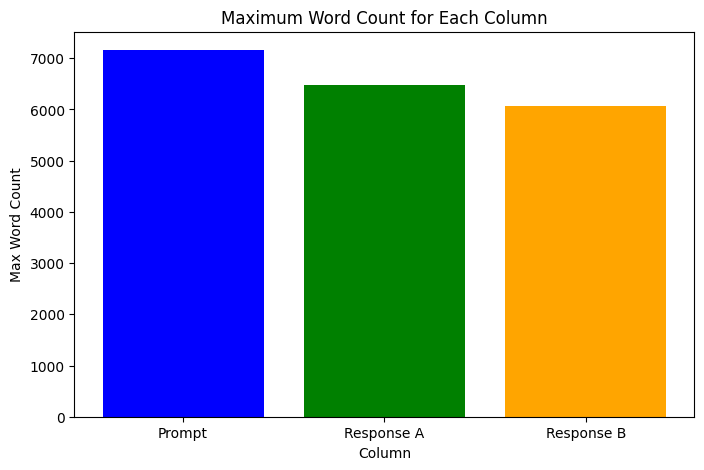

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


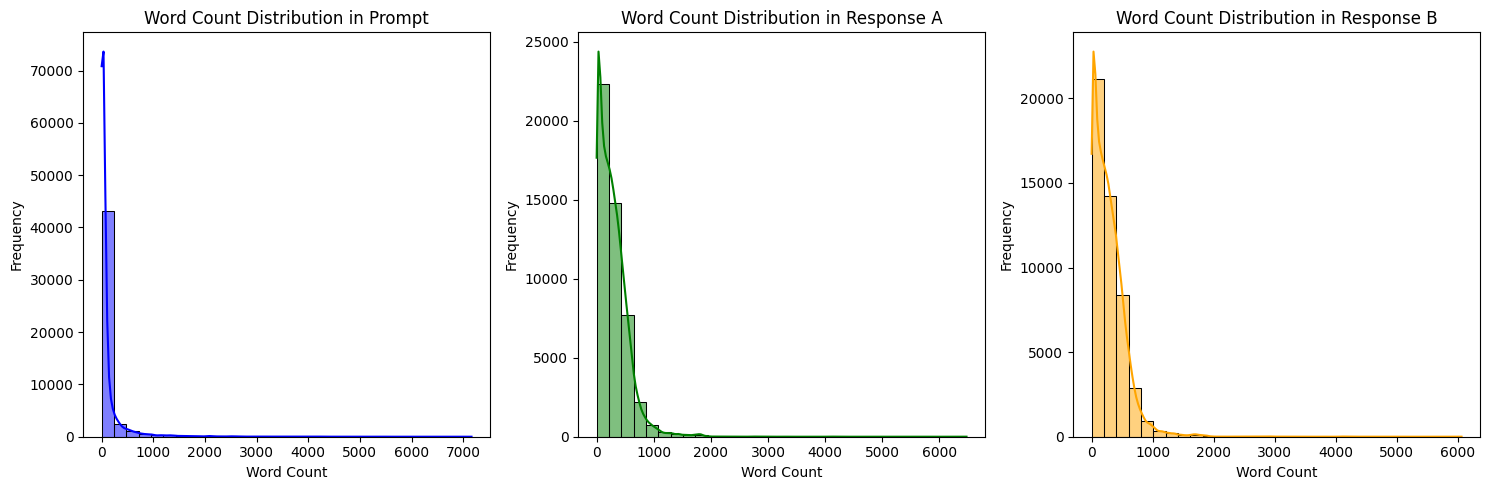

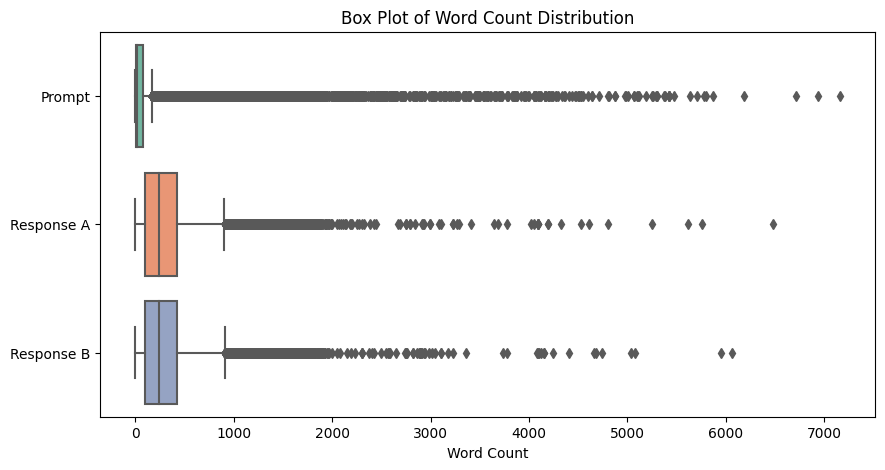

In [10]:
# Count words for each column ('prompt', 'response_a', 'response_b')
df['word_count_prompt'] = df['prompt'].apply(lambda x: len(str(x).split()))
df['word_count_response_a'] = df['response_a'].apply(lambda x: len(str(x).split()))
df['word_count_response_b'] = df['response_b'].apply(lambda x: len(str(x).split()))

# Find the maximum word count for each column
max_word_count_prompt = df['word_count_prompt'].max()
max_word_count_response_a = df['word_count_response_a'].max()
max_word_count_response_b = df['word_count_response_b'].max()

# Print the results
print("Maximum word count in 'prompt' column:", max_word_count_prompt)
print("Maximum word count in 'response_a' column:", max_word_count_response_a)
print("Maximum word count in 'response_b' column:", max_word_count_response_b)

# Optionally, find the rows with the maximum word count for each column
max_word_row_prompt = df.loc[df['word_count_prompt'].idxmax()]
max_word_row_response_a = df.loc[df['word_count_response_a'].idxmax()]
max_word_row_response_b = df.loc[df['word_count_response_b'].idxmax()]

# Display the rows with the maximum word count
print("\nRow with maximum word count in 'prompt' column:")
print(max_word_row_prompt)

print("\nRow with maximum word count in 'response_a' column:")
print(max_word_row_response_a)

print("\nRow with maximum word count in 'response_b' column:")
print(max_word_row_response_b)

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Bar Chart for Maximum Word Count in Each Column
max_word_counts = {
    'Prompt': max_word_count_prompt,
    'Response A': max_word_count_response_a,
    'Response B': max_word_count_response_b
}

# Plotting the bar chart
plt.figure(figsize=(8, 5))
plt.bar(max_word_counts.keys(), max_word_counts.values(), color=['blue', 'green', 'orange'])
plt.title('Maximum Word Count for Each Column')
plt.ylabel('Max Word Count')
plt.xlabel('Column')
plt.show()

# 2. Histograms for Word Count Distribution
plt.figure(figsize=(15, 5))

# Histogram for prompt
plt.subplot(1, 3, 1)
sns.histplot(df['word_count_prompt'], kde=True, color='blue', bins=30)
plt.title('Word Count Distribution in Prompt')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

# Histogram for response_a
plt.subplot(1, 3, 2)
sns.histplot(df['word_count_response_a'], kde=True, color='green', bins=30)
plt.title('Word Count Distribution in Response A')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

# Histogram for response_b
plt.subplot(1, 3, 3)
sns.histplot(df['word_count_response_b'], kde=True, color='orange', bins=30)
plt.title('Word Count Distribution in Response B')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# 3. Box Plot for Word Count Distribution
plt.figure(figsize=(10, 5))
sns.boxplot(data=[df['word_count_prompt'], df['word_count_response_a'], df['word_count_response_b']], 
            orient="h", palette="Set2")
plt.yticks([0, 1, 2], ['Prompt', 'Response A', 'Response B'])
plt.title('Box Plot of Word Count Distribution')
plt.xlabel('Word Count')
plt.show()


In [11]:
# Calculate the mean and mode for each column
mean_word_count_prompt = df['word_count_prompt'].mean()

mean_word_count_response_a = df['word_count_response_a'].mean()

mean_word_count_response_b = df['word_count_response_b'].mean()

print("Mean and Mode Word Count:")
print(f"Prompt Column: Mean = {mean_word_count_prompt:.2f}")
print(f"Response A Column: Mean = {mean_word_count_response_a:.2f}")
print(f"Response B Column: Mean = {mean_word_count_response_b:.2f}")


Mean and Mode Word Count:
Prompt Column: Mean = 121.66
Response A Column: Mean = 293.45
Response B Column: Mean = 294.14


In [12]:
ds = Dataset.from_csv("/kaggle/working/train.csv")
print(len(ds))
#ds = ds.select(torch.arange(10_000))  # We only use the first 100 data for demo purpose

Generating train split: 0 examples [00:00, ? examples/s]

48439


In [13]:
# class CustomTokenizer:
#     def __init__(self, tokenizer: PreTrainedTokenizerBase, max_length: int) -> None:
#         self.tokenizer = tokenizer
#         self.max_length = max_length
        
#     def __call__(self, batch: dict) -> dict:
#         processed_data = {"input_ids": [], "attention_mask": [], "labels": []}
        
#         for i in range(len(batch["prompt"])):
#             try:
#                 # Process and concatenate text parts
#                 prompt = "<prompt>: " + self.process_text(batch["prompt"][i])
#                 response_a = "\n\n<response_a>: " + self.process_text(batch["response_a"][i])
#                 response_b = "\n\n<response_b>: " + self.process_text(batch["response_b"][i])
#                 text = prompt + response_a + response_b

#                 # Tokenize the text
#                 tokenized = self.tokenizer(
#                     text, 
#                     max_length=self.max_length, 
#                     truncation=True, 
#                     padding="max_length"
#                 )
                
#                 # Handle the winner label
#                 winner = batch["winner"][i]
#                 if winner == "model_a":
#                     label = 0
#                 elif winner == "model_b":
#                     label = 1
#                 else:
#                     continue  # Skip rows with invalid winner labels
                
#                 # Append tokenized data to the processed data
#                 processed_data["input_ids"].append(tokenized["input_ids"])
#                 processed_data["attention_mask"].append(tokenized["attention_mask"])
#                 processed_data["labels"].append(label)
            
#             except Exception as e:
#                 # Log the error and continue (optional)
#                 print(f"Skipping row {i} due to error: {e}")
        
#         return processed_data

#     @staticmethod
#     def process_text(text: str) -> str:
#         if text is None:
#             return "" 
#         return text.replace("null", "").strip()


In [15]:
from transformers import PreTrainedTokenizerBase

class CustomTokenizer:
    def __init__(self, tokenizer: PreTrainedTokenizerBase, max_length: int = 1024, instruction: str = None) -> None:
        """
        Custom tokenizer to process and tokenize prompt-response pairs with balanced token allocation.

        Args:
            tokenizer (PreTrainedTokenizerBase): The tokenizer to use.
            max_length (int): Maximum token length for the combined input.
            instruction (str): The instruction text to be included with each input.
        """
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.max_per_section = max_length // 3  # Allocate approximately 1/3 of max_length to each part
        self.instruction = instruction or "<instruction>: Compare two responses and decide which one answers the prompt better."

    def __call__(self, batch: dict) -> dict:
        """
        Tokenizes and processes a batch of data, ensuring balanced token distribution
        across prompt, response_a, and response_b.

        Args:
            batch (dict): A dictionary containing "prompt", "response_a", "response_b", and "winner".

        Returns:
            dict: Processed batch with tokenized input_ids, attention_mask, and labels.
        """
        processed_data = {"input_ids": [], "attention_mask": [], "labels": []}
        
        for i in range(len(batch["prompt"])):
            try:
                # Process text parts
                instruction = self.instruction
                prompt = self.process_text(batch["prompt"][i])
                response_a = self.process_text(batch["response_a"][i])
                response_b = self.process_text(batch["response_b"][i])
                
                # Combine instruction and text parts
                combined_text = (
                    instruction + "\n\n" +
                    "<prompt>: " + prompt + "\n\n" +
                    "<response_a>: " + response_a + "\n\n" +
                    "<response_b>: " + response_b
                )
                
                # Tokenize the combined text
                tokenized = self.tokenizer(
                    combined_text,
                    max_length=self.max_length,
                    truncation=True,
                    padding="max_length"
                )
                
                # Handle the winner label
                winner = batch["winner"][i]
                if winner == "model_a":
                    label = 0
                elif winner == "model_b":
                    label = 1
                else:
                    continue  # Skip rows with invalid winner labels
                
                # Append processed data
                processed_data["input_ids"].append(tokenized["input_ids"])
                processed_data["attention_mask"].append(tokenized["attention_mask"])
                processed_data["labels"].append(label)
            
            except Exception as e:
                # Log the error and continue (optional)
                print(f"Skipping row {i} due to error: {e}")
        
        return processed_data

    @staticmethod
    def process_text(text: str) -> str:
        """
        Cleans and preprocesses text by removing null values and extra spaces.

        Args:
            text (str): Input text to process.

        Returns:
            str: Cleaned text.
        """
        if text is None:
            return ""
        return text.replace("null", "").strip()

# Define your instruction
instruction = """In the text provided below, PROMPT is the question presented; MODEL_A is the response from the first model; MODEL_B is the response from the second model. Please select the best answer from the two responses above. If the first answer is better, return "model_a"; if the second answer is better, return "model_b"."""

# Initialize the tokenizer with instruction
encode = CustomTokenizer(tokenizer, max_length=config.max_length, instruction=instruction)

# Apply the tokenizer to the dataset
ds = ds.map(encode, batched=True)


Map:   0%|          | 0/48439 [00:00<?, ? examples/s]

### Compute metrics

We'll compute the log-loss used in LB and accuracy as a auxiliary metric.

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import EvalPrediction

def compute_metrics(eval_pred: EvalPrediction) -> dict:
    # Extract predictions and labels from the EvalPrediction object
    logits, labels = eval_pred.predictions, eval_pred.label_ids

    # Convert logits to predicted labels (assuming binary classification with logits)
    pred_labels = logits.argmax(axis=-1)  # For multi-class, use argmax along the correct axis

    # Calculate accuracy and other metrics
    accuracy = accuracy_score(labels, pred_labels)
    precision = precision_score(labels, pred_labels, average='binary')
    recall = recall_score(labels, pred_labels, average='binary')
    f1 = f1_score(labels, pred_labels, average='binary')

    # Return the metrics as a dictionary
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }


### Split

Here, train and eval is splitted according to their `id % 5`

In [ ]:
from transformers.integrations import WandbCallback

folds = [
    (
        [i for i in range(len(ds)) if i % config.n_splits != fold_idx],
        [i for i in range(len(ds)) if i % config.n_splits == fold_idx]
    )
    for fold_idx in range(config.n_splits)
]

# Select train and evaluation indices for the current fold
train_idx, eval_idx = folds[config.fold_idx]

# Initialize Trainer with train and evaluation datasets
trainer = Trainer(
    args=training_args, 
    model=model,
    tokenizer=tokenizer,
    train_dataset=ds.select(train_idx),
    eval_dataset=ds.select(eval_idx),
    compute_metrics=compute_metrics,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    callbacks=[WandbCallback]
)

# Train the model
trainer.train(resume_from_checkpoint="/kaggle/input/new-gemma-7000-checkpoint/output/checkpoint-7000")


/tmp/ipykernel_23/3454113584.py:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
You are adding a <class 'transformers.integrations.integration_utils.WandbCallback'> to the callbacks of this Trainer, but there is already one. The currentlist of callbacks is
:DefaultFlowCallback
WandbCallback
/opt/conda/lib/python3.10/site-packages/transformers/trainer.py:3354: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no lo

Step,Training Loss,Validation Loss


In [ ]:
trainer.save_model()